In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
from scipy import stats
from tqdm import tqdm

In [4]:
df = pd.read_csv("../demo/hge.txt")
X = df["tz"].values

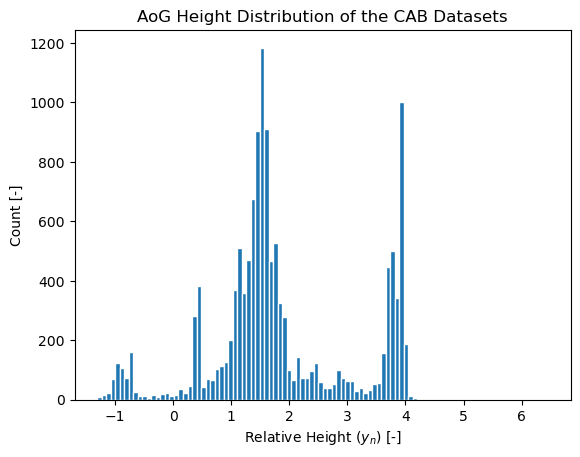

In [5]:
_ = plt.hist(X, bins=100, edgecolor='white')
_ = plt.ylabel(r"Count [-]")
_ = plt.xlabel(r"Relative Height ($y_n$) [-]")
_ = plt.title("AoG Height Distribution of the CAB Datasets")

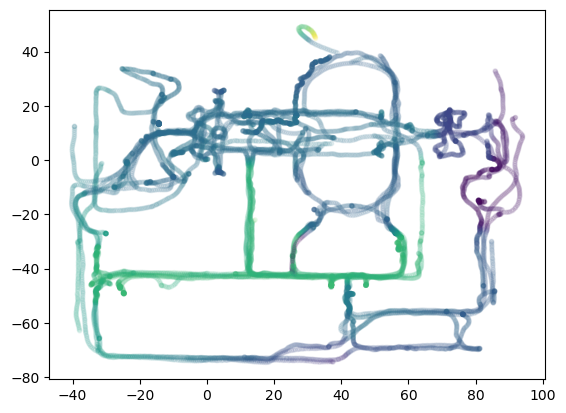

In [6]:
_ = plt.scatter(df["tx"], df["ty"], marker='.', alpha=0.1, c=df["tz"])

### Gaussian Mixture Model without Latent Height, $\mathbf H$

In [7]:
"""
Functions
 - countnk = Yields K-dimensional vector containing cluster count
 - pzkz = Computes the first term of the full-conditional
 - pxxzz = Computes the second term of the full-conditional, the posterior predictive
"""

def countnk(Z, K): 
    Nk = np.zeros((K,))
    unique, count = np.unique(Z, return_counts=True)
    Nk[unique] += count
    return Nk

def pzkz(Z, K, N, n, alpha): 
    Nk = countnk(Z, K)
    Nk[Z[n]] -= 1
    denom = N - 1 + alpha
    return (Nk + alpha / K) / denom

def pxxzz(Z, K, X, n, mu0, var, alpha, beta): 
    Xn = X[n]
    Nk = countnk(Z, K)
    Nk[Z[n]] -= 1
    P = np.zeros((K,))
    
    for i in range(K): 
        Di = X[Z == i]
        Ni = Nk[i]
        mean = np.mean(Di)
        mui = (Ni * mean + var * mu0) / (var + Ni)
        vari = var + Ni
        alphai = alpha + Ni / 2
        betai = beta + 0.5 * np.sum(np.square(Di - mean))
        betai += 0.5 * (Ni * var * np.square(mean - mu0)) / (var + Ni)
        P[i] = t.pdf(Xn, 2 * alphai, mui, np.sqrt(betai * (vari + 1) / vari / alphai))
        
    return P

In [17]:
"""
Variables
 - K = Number of Clusters
 - N = Number of Samples, or Data Points
 - Z = N-dimensional Vector of Class Assignment, Zn for Xn
 - n = Current Sampling Index, within range [0, N)
 - alpha = Hyper-parameters for the Mixtures
 - alpha0 = Hyper-parameters for Cluster's Precision
 - beta0 = Hyper-parameters for Cluster's Precision
 - mu0 = Hyper-parameters for Cluster's Mean
 - var = Hyper-parameters for Cluster's Mean
"""

K = 5
alpha = 1
alpha0 = 1
beta0 = 1
mu0 = 0
var = 20
seed = 122
    

def dpmm(S, X, K, alpha, alpha0, beta0, mu0, var, seed = None): 
    if seed != None: 
        np.random.seed(seed)
    
    n = 0
    N = X.size
    H = np.zeros((S, N), dtype=int)
    
    temp = np.linspace(np.min(X), np.max(X), K, endpoint=False)
    for i, fl in enumerate(temp): 
        HI = H[0]
        HI[X > fl] = i
        
    for s in tqdm(range(1, S), ncols=100): 
        Z = H[s - 1]
        p = pzkz(Z, K, N, n, alpha) * pxxzz(Z, K, X, n, mu0, var, alpha0, beta0)
        z = np.random.choice(np.arange(K), p=p/np.sum(p))
        H[s] = Z
        H[s, n] = z
        n = (n + 1) % N
        
    return K, H
    
K, Z = dpmm(X.size * 3, X, 2, alpha, alpha0, beta0, mu0, var, seed)

100%|████████████████████████████████████████████████████████| 39839/39839 [00:40<00:00, 981.76it/s]


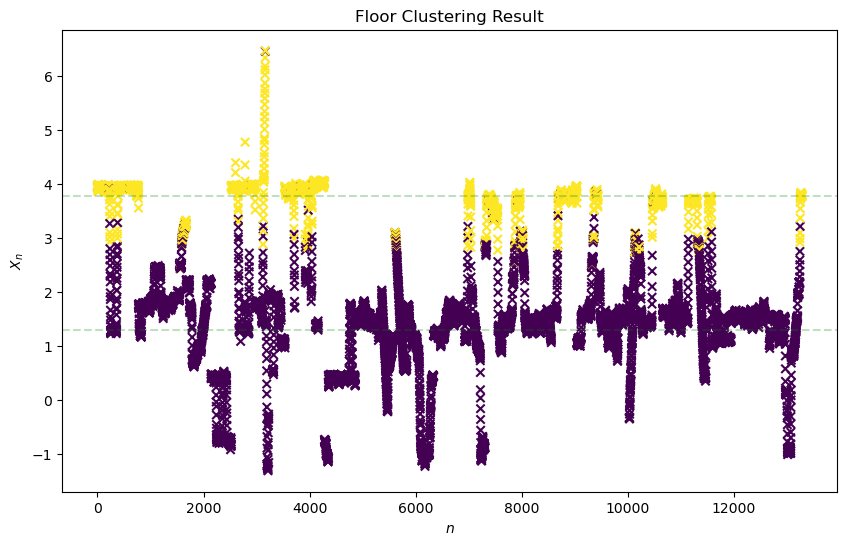

In [23]:
Xt = X
N = Xt.size
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.arange(N), Xt, marker="x", c=Z[-1])
Zi = Z[-1]

plt.xlabel(r"$n$")
plt.ylabel(r"$X_n$")
plt.title(r"Floor Clustering Result")

temp = []

for k in range(K): 
    center = np.mean(Xt[Zi == k])
    std = np.std(Xt[Zi == k])
    ax.axhline(center, linestyle="--", color='green', alpha=0.25)
    temp.append(center - 2 * std)
    
temp.append(np.max(Xt))

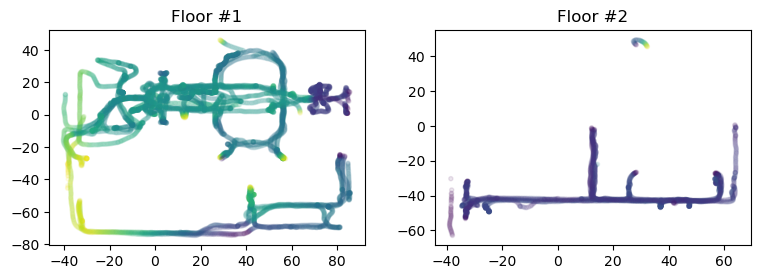

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout(pad=2)

for idx, (ax, start, end) in enumerate(zip(axes.flatten(), temp[:-1], temp[1:])):
    mask = (df["tz"] >= start) & (df["tz"] < end)
    ax.scatter(df["tx"][mask], df["ty"][mask], marker=".", alpha=0.1, c=df["tz"][mask])
    ax.set_title("Floor #%d" % (idx + 1))

### Position to 4D Hexagonal Index

In [25]:
def cube_to_axial(q, r, s): 
    return q, r
    
def axial_to_cube(q, r): 
    s = -q-r
    return q, r, s

def cube_round(fq, fr, fs): 
    q = round(fq)
    r = round(fr)
    s = round(fs)
    
    dq = abs(q - fq)
    dr = abs(r - fr)
    ds = abs(s - fs)
    
    if dq > dr and dq > ds: 
        q = -r-s
    elif dr > ds: 
        r = -q-s
    else:
        s = -q-r
    
    return q, r, s

def axial_round(q, r): 
    q, r, s = axial_to_cube(q, r)
    q, r, s = cube_round(q, r, s)
    return cube_to_axial(q, r, s)

def xyz_to_hex(x, y, z, size=1, center=(0, 0)): 
    x = x - center[0]
    y = y - center[1]
    A = np.array([[np.sqrt(3)/3, -1/3], [0, 2/3]])
    x = np.array([x, y])
    b = (A @ x) / size
    q = b[0]
    r = b[1]
    return axial_round(q, r)

def hex_to_key(q, r): 
    return "{},{}".format(q, r)

def xyz_to_key(x, y, z, size=1, center=(0, 0)): 
    q, r = xyz_to_hex(x, y, z, size, center)
    return hex_to_key(q, r)

In [26]:
def generate_groups(batch_x, batch_y): 
    groups = {}
    for x, y in zip(batch_x, batch_y):
        hexa = xyz_to_key(x, y, 0.0, size=7)
        
        if hexa not in groups: 
            groups[hexa] = []
        
        groups[hexa].append([x, y])
    
    result = []
    for group in groups.values():
        result.append(np.array(group))
        
    return result

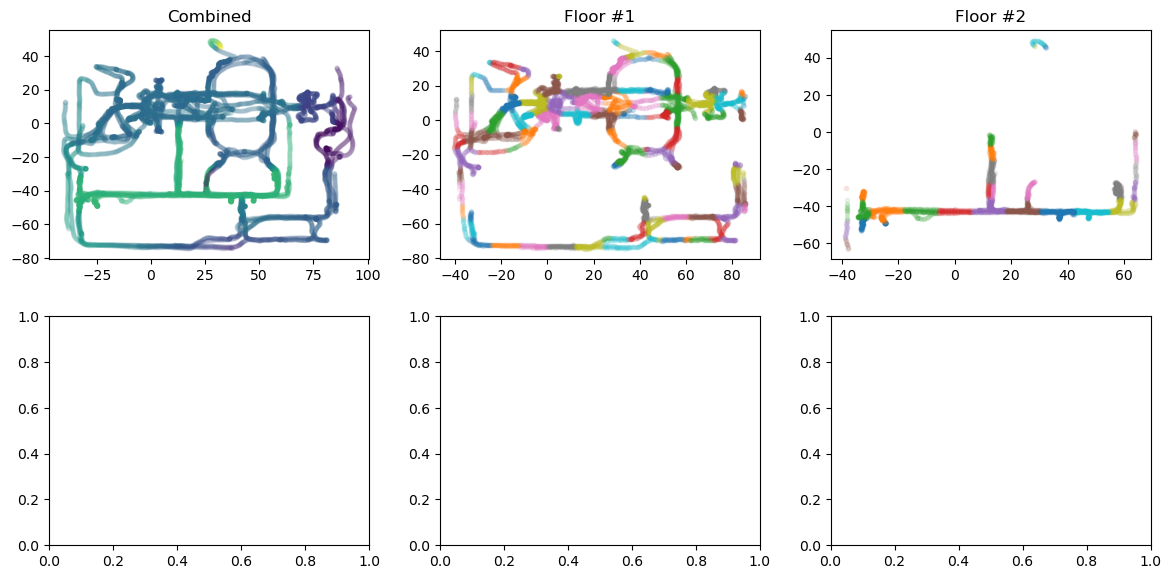

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.tight_layout(pad=2)
axes[0, 0].scatter(df["tx"], df["ty"], marker='.', alpha=0.1, c=df["tz"])
axes[0, 0].set_title("Combined")

for idx, (ax, start, end) in enumerate(zip(axes.flatten()[1:], temp[:-1], temp[1:])):
    mask = (df["tz"] >= start) & (df["tz"] < end)
    for group in generate_groups(df["tx"][mask], df["ty"][mask]): 
        ax.scatter(group[:, 0], group[:, 1], marker=".", alpha=0.1)
    ax.set_title("Floor #%d" % (idx + 1))